In [52]:
import warnings
warnings.filterwarnings('ignore')

import fasttext
import en_core_web_sm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nlpaug.augmenter.word as naw

from tqdm.notebook import tqdm
from typing import Iterable
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model

from torchtext.vocab import FastText
from torchtext.data import Example, Field, Dataset, NestedField, BucketIterator

%matplotlib inline

In [2]:
train = pd.read_json("data/train.jsonl", lines=True, orient="records")
dev = pd.read_json("data/dev.jsonl", lines=True, orient="records")

In [3]:
train["answer"] = train["answer"].astype(int)
dev["answer"] = dev["answer"].astype(int)

## Part 1. EDA

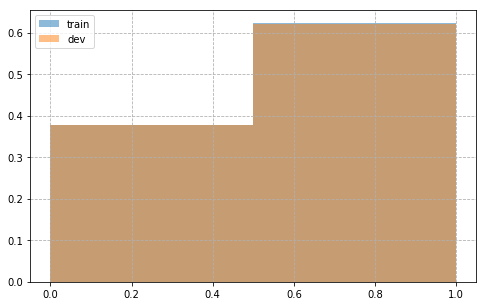

  Class distribution   

      |   No   |  Yes  
-----------------------
Train | 0.3769 | 0.6231
Dev   | 0.3783 | 0.6217


In [4]:
# Class distribution
plt.figure(figsize=(8,5))

weights = np.ones(train.shape[0]) / train.shape[0]
train_dist, _, _ = plt.hist(train["answer"], bins=2, weights=weights, label="train", alpha=0.5)

weights = np.ones(dev.shape[0]) / dev.shape[0]
dev_dist, _, _ = plt.hist(dev["answer"], bins=2, weights=weights, label="dev", alpha=0.5)

plt.grid(ls='--')
plt.legend()

plt.show()

print("  Class distribution   ")
print()
print("      |   No   |  Yes  ")
print("-----------------------")
print("Train | {:.4f} | {:.4f}".format(*train_dist))
print("Dev   | {:.4f} | {:.4f}".format(*dev_dist))

In [5]:
# Average question length
print("Average question length")
print()
print("Train: {:.2f}".format(train["question"].apply(lambda x: len(x)).agg(np.mean)))
print("Dev  : {:.2f}".format(dev["question"].apply(lambda x: len(x)).agg(np.mean)))

Average question length

Train: 43.99
Dev  : 43.21


In [6]:
# Average passage length
print("Average passage length")
print()
print("Train: {:.2f}".format(train["passage"].apply(lambda x: len(x)).agg(np.mean)))
print("Dev  : {:.2f}".format(dev["passage"].apply(lambda x: len(x)).agg(np.mean)))

Average passage length

Train: 565.61
Dev  : 559.05


In [7]:
# Heuristics
# In English yes/no answers are usually used with particular question structure.
# As we can see, top-9 first question words in train and dev splits are identical.
# So heuristic could be the following: select questions, where first word lies in the list.
# From the paper we find that they used the following list:
# {“did”, “do”, “does”, “is”, “are”, “was”, “were”, “have”, “has”, “can”, “could”, “will”, “would”}
print("----- Train -----")
print(train["question"].apply(lambda x: x.split()[0]).value_counts()[:9])
print()
print("-----  Dev  -----")
print(dev["question"].apply(lambda x: x.split()[0]).value_counts()[:9])

----- Train -----
is      4190
can     1136
does     952
are      693
do       664
did      461
was      335
has      302
will     181
Name: question, dtype: int64

-----  Dev  -----
is      1532
can      394
does     373
are      251
do       243
did      134
has      124
was      104
will      68
Name: question, dtype: int64


## Part 2. Baseline

In [8]:
# Naive
# For every question predict True -- the most represented class in the train split
y_true = dev["answer"]
y_pred = np.ones(dev.shape[0])
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6217


In [9]:
# Fasttext
fasttext_train = pd.DataFrame()
fasttext_train["answer"] = "__label__" + train["answer"].astype(str)
fasttext_train["text"] = train["question"] + " " + train["passage"]
fasttext_train.to_csv("data/fasttext_train.csv", index=False, sep="\t")

model = fasttext.train_supervised("data/fasttext_train.csv")

y_true = dev["answer"]
y_pred = [int(model.predict(sent)[0][0][-1]) for sent in dev["question"] + " "+ dev["passage"]]
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6474


## Part 3. Embeddings

### Transformers

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model = model.eval()

In [11]:
def embed_sentence(sentence: str = None) -> np.array:
    sentence = "[CLS] " + sentence + " [SEP]"
    tokenized = tokenizer.tokenize(sentence)
    indexed = tokenizer.convert_tokens_to_ids(tokenized)
    segments = [1] * len(tokenized)

    tokens = torch.tensor([indexed])
    segments = torch.tensor([segments])

    with torch.no_grad():
        out = model(tokens, segments)

    return torch.mean(out[2][11][0], dim=0).numpy()
        

def embed_collection(collection: Iterable = None) -> np.array:
    return np.array(
        [np.mean([embed_sentence(sentence=sent) for sent in sent_tokenize(item)], axis=0) for item in collection]
    )

In [12]:
x_train_passage = np.array(embed_collection(collection=train["passage"]))
x_train_question = np.array(embed_collection(collection=train["question"]))
x_dev_passage = np.array(embed_collection(collection=dev["passage"]))
x_dev_question = np.array(embed_collection(collection=dev["question"]))

In [13]:
x_train = np.hstack((x_train_passage, x_train_question))
x_dev = np.hstack((x_dev_passage, x_dev_question))

In [14]:
model = LogisticRegression()
model.fit(x_train, train["answer"])

y_true = dev["answer"]
y_pred = model.predict(x_dev)
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6612


### UKPLab

In [15]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [16]:
def embed_collection(collection: Iterable = None) -> np.array:
    return np.array([np.mean(model.encode(sent_tokenize(item)), axis=0) for item in collection])

In [17]:
x_train_passage_ukp = np.array(embed_collection(collection=train["passage"]))
x_train_question_ukp = np.array(embed_collection(collection=train["question"]))
x_dev_passage_ukp = np.array(embed_collection(collection=dev["passage"]))
x_dev_question_ukp = np.array(embed_collection(collection=dev["question"]))

In [18]:
x_train_ukp = np.hstack((x_train_passage_ukp, x_train_question_ukp))
x_dev_ukp = np.hstack((x_dev_passage_ukp, x_dev_question_ukp))

In [19]:
model = LogisticRegression()
model.fit(x_train_ukp, train["answer"])

y_true = dev["answer"]
y_pred = model.predict(x_dev_ukp)
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6569


### Hugging Face

In [20]:
tokenizer =  GPT2Tokenizer.from_pretrained('gpt2')

model = GPT2Model.from_pretrained('gpt2', output_hidden_states=True)
model = model.eval()

In [21]:
def embed_sentence(sentence: str = None) -> np.array:
    tokens = torch.tensor(tokenizer.encode(sentence, add_special_tokens=True)).unsqueeze(0)

    with torch.no_grad():
        out = model(tokens)

    return torch.mean(out[2][11][0], dim=0).numpy()
        

def embed_collection(collection: Iterable = None) -> np.array:
    return np.array(
        [np.mean([embed_sentence(sentence=sent) for sent in sent_tokenize(item)], axis=0) for item in collection]
    )

In [22]:
x_train_passage_gpt = np.array(embed_collection(collection=train["passage"]))
x_train_question_gpt = np.array(embed_collection(collection=train["question"]))
x_dev_passage_gpt = np.array(embed_collection(collection=dev["passage"]))
x_dev_question_gpt = np.array(embed_collection(collection=dev["question"]))

In [23]:
x_train_gpt = np.hstack((x_train_passage_gpt, x_train_question_gpt))
x_dev_gpt = np.hstack((x_dev_passage_gpt, x_dev_question_gpt))

In [24]:
model = LogisticRegression()
model.fit(x_train_gpt, train["answer"])

y_true = dev["answer"]
y_pred = model.predict(x_dev_gpt)
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6569


### Augmentation

In [44]:
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="substitute")

In [45]:
# Add more "no" questions to the training split
indices = np.random.choice(np.array(train[train["answer"] == 0].index), size=10, replace=False)

In [46]:
augmented_passage = [aug.augment(passage) for passage in train["passage"][indices]]
augmented_question = [aug.augment(question) for question in train["question"][indices]]

In [47]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
model = model.eval()

In [48]:
def embed_sentence(sentence: str = None) -> np.array:
    sentence = "[CLS] " + sentence + " [SEP]"
    tokenized = tokenizer.tokenize(sentence)
    indexed = tokenizer.convert_tokens_to_ids(tokenized)
    segments = [1] * len(tokenized)

    tokens = torch.tensor([indexed])
    segments = torch.tensor([segments])

    with torch.no_grad():
        out = model(tokens, segments)

    return torch.mean(out[2][11][0], dim=0).numpy()
        

def embed_collection(collection: Iterable = None) -> np.array:
    return np.array(
        [np.mean([embed_sentence(sentence=sent) for sent in sent_tokenize(item)], axis=0) for item in collection]
    )

In [49]:
x_train_aug_passage = np.array(embed_collection(collection=augmented_passage))
x_train_aug_question = np.array(embed_collection(collection=augmented_question))

In [50]:
x_train_aug = np.hstack((x_train_aug_passage, x_train_aug_question))
x_train_augmented = np.vstack((x_train, x_train_aug))
y_train_augmented = np.append(train["answer"].to_numpy(), train["answer"][indices].to_numpy())

In [51]:
model = LogisticRegression()
model.fit(x_train_augmented, y_train_augmented)

y_true = dev["answer"]
y_pred = model.predict(x_dev)
print("Accuracy: {:.4f}".format(accuracy_score(y_true, y_pred)))

Accuracy: 0.6618


## Part 4. DrQA

In [53]:
nlp = en_core_web_sm.load()

In [54]:
class DataLoader:
    def __init__(self):
        self.char_field = NestedField(
            Field(batch_first=True, tokenize=list, lower=True),
            init_token="<SOS>",
            eos_token="<EOS>",
            tokenize="spacy",
        )
        self.word_field = Field(
            init_token="<SOS>",
            eos_token="<EOS>",
            lower=True,
            tokenize="spacy",
        )
        self.target_field = Field(
            is_target=True,
            sequential=False,
            use_vocab=False,
        )

        self.fields = [
                ("question_char", self.char_field),
                ("context_char", self.char_field),
                ("question", self.word_field),
                ("context", self.word_field),
                ("answer", self.target_field),
        ]
        self.dict_fields = {
            "context": [("context_char", self.char_field), ("context", self.word_field)],
            "question": [("question_char", self.char_field), ("question", self.word_field)],
            "answer": ("answer", self.target_field),
        }

    def create_dataset(self, path: str = None) -> Dataset:
        df = pd.read_json(path, lines=True, orient="records")

        data = pd.DataFrame()
        data["context"] = df["title"] + " " + df["passage"]
        data["question"] = df["question"]
        data["answer"] = df["answer"]

        items = data.to_dict("records")

        return Dataset([Example.fromdict(item, fields=self.dict_fields) for item in items], self.fields)

    def build(self, train_path: str = None, dev_path: str = None) -> None:
        self.train = self.create_dataset(path=train_path)
        self.dev = self.create_dataset(path=dev_path)

        self.char_field.build_vocab(self.train)
        self.word_field.build_vocab(self.train, vectors=FastText(language="en", max_vectors=30000))

        pos, ner = [], []
        ind2pos, ind2ner = [], []

        for data in self.train:
            doc = nlp(" ".join(data.question) + " " + " ".join(data.context))

            pos.extend([token.pos_ for token in doc])
            ner.extend([token.label_ for token in doc.ents])

            ind2pos.extend([(self.word_field.vocab.stoi[str(token)], token.pos_) for token in doc])
            ind2ner.extend([(self.word_field.vocab.stoi[str(token)], token.label_) for token in doc.ents])

        self.pos_vocab = {tag: i for i, tag in enumerate(set(pos))}
        self.ner_vocab = {tag: i + 1 for i, tag in enumerate(set(ner))}
        self.ner_vocab["<UNK>"] = 0

        self.ind2pos = {tag[0]: self.pos_vocab[tag[1]] for tag in ind2pos}
        self.ind2ner = {tag[0]: self.ner_vocab[tag[1]] for tag in ind2ner}

In [55]:
loader = DataLoader()
loader.build(train_path="data/train.jsonl", dev_path="data/dev.jsonl")

.vector_cache/wiki.en.vec: 6.60GB [48:25, 2.27MB/s]                                
100%|██████████| 30000/30000 [00:04<00:00, 7284.50it/s]


In [56]:
train_iter = BucketIterator(loader.train, batch_size=32, shuffle=True, sort_key=lambda x: len(x.context))
dev_iter = BucketIterator(loader.dev, batch_size=128, shuffle=True, sort_key=lambda x: len(x.context))

In [57]:
class Model(nn.Module):
    def __init__(
        self,
        loader,
        weights,
        emb_dim: int = None,
        lstm_dim: int = None,
        hidden_size: int = None,
        dropout: float = None
    ):
        super().__init__()

        self.loader = loader

        self.emb_dim = emb_dim
        self.lstm_dim = lstm_dim
        self.hidden_size = hidden_size
        
        self.emb = nn.Embedding.from_pretrained(weights, freeze=True)
        
        self.lstm_context = nn.LSTM(
            input_size=self.lstm_dim,
            hidden_size=self.hidden_size // 2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )
        self.lstm_question = nn.LSTM(
            input_size=self.emb_dim,
            hidden_size=self.hidden_size // 2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout,
        )

        self.alpha = nn.Linear(self.emb_dim, 1)
        
        self.linear = nn.Linear(4 * hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 2)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)

    def ner(self, context):
        result = torch.zeros((context.shape[0], context.shape[1], len(self.loader.ner_vocab)))

        for i in range(context.shape[0]):
            for j in range(context.shape[1]):
                out = torch.zeros(len(self.loader.ner_vocab))

                if context[i][j] not in self.loader.ind2ner:
                    out[self.loader.ner_vocab["<UNK>"]] = 1
                else:
                    out[self.loader.ner_vocab[context[i][j]]] = 1

                result[i, j, :] = out

        return result

    def pos(self, context):
        result = torch.zeros((context.shape[0], context.shape[1], len(self.loader.pos_vocab)))

        for i in range(context.shape[0]):
            for j in range(context.shape[1]):
                out = torch.zeros(len(self.loader.pos_vocab))

                if context[i][j] not in self.loader.ind2pos:
                    out[self.loader.pos_vocab["X"]] = 1
                else:
                    out[self.loader.pos_vocab[context[i][j]]] = 1

                result[i, j, :] = out

        return result

    def match(self, context, question):
        result = torch.zeros((context.shape[0], context.shape[1], 1))

        for i in range(context.shape[0]):
            for j in range(context.shape[1]):
                out = 1 if context[i][j] in question[i] else 0
                result[i, j] = torch.tensor(out)

        return result

    def align(self, context_emb, question_emb):
        value = torch.exp(F.leaky_relu(self.alpha(context_emb.float())))

        context = torch.tensor([value for _ in range(len(question_emb))])
        question = torch.tensor([F.leaky_relu(self.alpha(q.float())) for q in question_emb])

        total = torch.sum(context * question, dim=0)
        out = torch.sum((context * question)[:, None] * question_emb / total, dim=0)

        return out

    def attention(self, context_emb, question_emb):
        result = torch.zeros((context_emb.shape[0], context_emb.shape[1], self.emb_dim))

        for i in range(context_emb.shape[0]):
            for j in range(context_emb.shape[1]):
                result[i, j] = self.align(context_emb[i][j], question_emb[i])

        return result

    def forward(self, batch):
        context = batch.context.transpose(0, 1)
        question = batch.question.transpose(0, 1)

        context_emb = self.emb(context)
        question_emb = self.emb(question)

        context_ner = self.ner(context)
        context_pos = self.pos(context)
        context_match = self.match(context, question)
        context_attention = self.attention(context_emb, question_emb)
        context_features = torch.cat((
            context_emb, context_ner, context_pos, context_attention, context_match
        ), dim=2)
        context_features = self.dropout(context_features)

        _, context_out = self.lstm_context(context_features)
        _, question_out = self.lstm_question(question_emb)

        batch_size = batch.context.shape[1]

        context_out = torch.cat((
            context_out[0].permute(1, 0, 2).reshape(batch_size, self.hidden_size),
            context_out[1].permute(1, 0, 2).reshape(batch_size, self.hidden_size)
        ), dim=1)
        question_out = torch.cat((
            question_out[0].permute(1, 0, 2).reshape(batch_size, self.hidden_size),
            question_out[1].permute(1, 0, 2).reshape(batch_size, self.hidden_size)
        ), dim=1)

        features = torch.cat((context_out, question_out), dim=1)

        out = self.linear(self.flatten(features))
        out = self.dropout(out)
        out = self.out(out)

        return out

In [58]:
class ModelTrainer:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
    def on_epoch_begin(self, is_train, name, batches_count) -> None:
        self.epoch_loss = 0
        self.correct_count, self.total_count = 0, 0
        self.is_train = is_train
        self.name = name
        self.batches_count = batches_count
        self.model.train(is_train)
        
    def on_epoch_end(self) -> str:
        return '{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
            self.name, self.epoch_loss / self.batches_count, self.correct_count / self.total_count
        )
        
    def on_batch(self, batch) -> str:
        logits = self.model(batch)
        target = batch.answer
        prediction = torch.max(logits, axis=1)[1]

        loss = self.criterion(logits, target)

        self.total_count += prediction.size(0)
        self.correct_count += torch.sum(prediction == target).item()

        if self.is_train:
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
            self.optimizer.step()
            self.optimizer.zero_grad()

        self.epoch_loss += loss.item()

        return '{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
            self.name, loss.item(), torch.sum(prediction == target).item() / prediction.size(0)
        )

In [59]:
tqdm.get_lock().locks = []

def do_epoch(
    trainer: ModelTrainer = None,
    data_iter: BucketIterator = None,
    is_train: bool = None,
    name: str = None
) -> None:
    trainer.on_epoch_begin(is_train=is_train, name=name, batches_count=len(data_iter))

    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=trainer.batches_count) as progress_bar:
            for i, batch in enumerate(data_iter):
                batch_progress = trainer.on_batch(batch=batch)

                progress_bar.update()
                progress_bar.set_description(batch_progress)

            epoch_progress = trainer.on_epoch_end()

            progress_bar.set_description(epoch_progress)
            progress_bar.refresh()

def fit(
    trainer: ModelTrainer = None,
    train_iter: BucketIterator = None,
    epochs_count: int = None,
    dev_iter: BucketIterator = None
) -> None:
    best_val_loss = None

    for epoch in range(epochs_count):
        try:
            name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
            do_epoch(trainer=trainer, data_iter=train_iter, is_train=True, name=name_prefix + 'Train:')

            if not dev_iter is None:
                do_epoch(trainer=trainer, data_iter=dev_iter, is_train=False, name=name_prefix + '  Val:')
        except KeyboardInterrupt:
            print("Early stopping")
            return

In [60]:
weights = loader.word_field.vocab.vectors
model = Model(loader=loader, weights=weights, emb_dim=300, lstm_dim=637, hidden_size=128, dropout=0.3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=1e-3)
trainer = ModelTrainer(model=model, criterion=criterion, optimizer=optimizer)
fit(trainer=trainer, train_iter=train_iter, epochs_count=10, dev_iter=dev_iter)

---

## Part 5. BiDAF

In [61]:
class Model(nn.Module):
    def __init__(
        self,
        weights,
        char_vocab_size: int = None,
        char_emb_dim: int = None,
        char_hidden_size: int = None,
        char_kernel_size: int = None,
        emb_dim: int = None,
        hidden_size: int = None,
        dropout: float = None,
    ):
        super().__init__()

        self.char_vocab_size = char_vocab_size
        self.char_emb_dim = char_emb_dim
        self.char_hidden_size = char_hidden_size
        self.char_kernel_size = char_kernel_size

        self.emb_dim = emb_dim
        self.hidden_size = hidden_size

        self.char_emb = nn.Embedding(self.char_vocab_size, self.char_emb_dim)
        self.word_emb = nn.Embedding.from_pretrained(weights, freeze=True)

        self.char_conv = nn.Conv2d(1, self.char_hidden_size, (self.char_emb_dim, self.char_kernel_size))

        self.alpha = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(6 * self.hidden_size, 1)
        )

        self.contextual_lstm = nn.LSTM(
            input_size=self.emb_dim + self.char_hidden_size,
            hidden_size=self.hidden_size,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.modeling_lstm_first = nn.LSTM(
            input_size=8 * self.hidden_size,
            hidden_size=self.hidden_size,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.modeling_lstm_second = nn.LSTM(
            input_size=2 * self.hidden_size,
            hidden_size=self.hidden_size,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )
        self.lstm = nn.LSTM(
            input_size=10 * hidden_size,
            hidden_size=self.hidden_size,
            bidirectional=True,
            batch_first=True,
            dropout=dropout
        )

        self.out = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(4 * hidden_size, 2)
        )

        self.dropout = nn.Dropout(p=dropout)

    def embed(self, batch):
        batch_size = batch.size(0)

        emb = self.char_emb(batch)
        emb = self.dropout(emb)

        emb = emb.transpose(2, 3)
        emb = emb.view(-1, self.char_emb_dim, emb.size(3)).unsqueeze(1)

        emb = self.char_conv(emb).squeeze()
        emb = F.max_pool1d(emb, emb.size(2)).squeeze()

        emb = emb.view(batch_size, -1, self.char_hidden_size)

        return emb

    def attention(self, context, question):
        tensor = torch.cat([
            context.unsqueeze(2).expand(context.size(0), context.size(1), question.size(1), -1),
            question.unsqueeze(1).expand(context.size(0), context.size(1), question.size(1), -1),
            context.unsqueeze(2) * question.unsqueeze(1)
        ], dim=-1)
        s = self.alpha(tensor).squeeze()

        a = F.softmax(s, dim=2)
        context_question_attention = torch.bmm(a, question)

        b = F.softmax(torch.max(s, dim=2)[0], dim=1).unsqueeze(1)
        question_context_attention = torch.bmm(b, context).squeeze()
        question_context_attention = question_context_attention.unsqueeze(1).expand(-1, context.size(1), -1)

        result = torch.cat([
                      context,
                      context_question_attention,
                      context * context_question_attention,
                      context * question_context_attention
        ], dim=-1)

        return result

    def forward(self, batch):
        context_char_emb = self.embed(batch.context_char)
        question_char_emb = self.embed(batch.question_char)
        
        context_word_emb = self.word_emb(batch.context.transpose(0, 1))
        question_word_emb = self.word_emb(batch.question.transpose(0, 1))

        context = torch.cat([context_char_emb, context_word_emb], dim=-1)
        question = torch.cat([question_char_emb, question_word_emb], dim=-1)

        context, _ = self.contextual_lstm(context)
        question, _ = self.contextual_lstm(question)

        g = self.attention(context, question)

        features, _ = self.modeling_lstm_first(g)
        features, _ = self.modeling_lstm_second(features)

        _, features = self.lstm(torch.cat([g, features], dim=-1))
        features = torch.cat((
            features[0].permute(1, 0, 2).reshape(batch.context.size(1), 2 * self.hidden_size),
            features[1].permute(1, 0, 2).reshape(batch.context.size(1), 2 * self.hidden_size)
        ), dim=1)

        out = self.out(features)

        return out

In [62]:
weights = loader.word_field.vocab.vectors
model = Model(
    weights=weights,
    char_vocab_size=len(loader.char_field.vocab),
    char_emb_dim=15,
    char_hidden_size=15,
    char_kernel_size=5,
    emb_dim=300,
    hidden_size=64,
    dropout=0.3
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
trainer = ModelTrainer(model=model, criterion=criterion, optimizer=optimizer)
fit(trainer=trainer, train_iter=train_iter, epochs_count=10, dev_iter=dev_iter)

## Part 6. Report

### Naive Baseline

Если предсказывать метку самого популярного класса в обучающей выборке, то можно добиться `accuracy=0.6217`.

### FastText Baseline

Если использовать FastText-эмбеддинги и логистическую регрессию, то можно добиться `accuracy=0.6486`. Возможно, улучшить результаты бейзлайнов можно было бы с помощью подбора параметроа логистической регрессии и нормализации данных: иногда встречаются символы не из английского алфавита -- FastText к такому вряд ли готов.

### BERT Embeddings

Один из самых успешных способов -- использовать BERT Embeddings и логистическую регрессию. С помощью этого подхода получаем `accuracy=0.6612`.

### GPT2 Embeddings

Все то же самое, что и в **BERT Embeddings**, только другая модель. Результаты получаются немного хуже: `accuracy=0.6569`.

### UKPLab Embeddings

Попробовал взять эмбеддинги из другого популярного фреймворка (используемая модель -- Cased BERT, обученный на NLI датасете). Прироста качества не наблюдается: `accuracy=0.6569`.

### Augmentation

Попробовал сбалансировать обучающую выборку: добавил больше отрицательных примеров (аугментация состоит в замене некоторых слов на ближайшие на основе их векторного представления, полученного с помощью эмбеддингов из Uncased BERT; использовал готовый фреймворк). Немного перебрал размер аугментации: добавив 10 примеров качество увеличилось: `accuracy=0.6615`.

### DrQA

Архитектура почти такая же, как и в оригинальной статье:
1. Эмбеддинг контекста:
    - FastText-эмбеддинги
    - OneHotEncoded-информация о NER-тегах
    - OneHotEncode-информация о POS-тегах
    - Выровненные с помощью SoftAttention FastText-эмбеддинги контекста и вопроса
2. Эмбеддинг вопроса:
    - FastText-эмбеддинги
3. Полученные в п.п.1-2 эмбеддинги подаются в BiLSTM (отдельные LSTM для контекста и вопроса). Output этих LSTM конкатенируются -- получили финальные пирзнаки.
4. Слой предсказания -- два линейных слоя

В такой реализации получается следующее качество: `accuracy=0.6508`

Думаю из-за того, что архитектура была придумана для SQuAD, в котором примерно в 8 раз больше данных, обучаться надо с помощью SGD с маленьким learning rate. Также поэкспериментировать с нормализационными слоями и дропаутом. Иначе будем быстро переобучаться 

### BiDAF

Архитектура почти такая же, как и в оригинальной статье:
1. Эмбеддинг контекста и вопроса:
    - Символьные эмбеддинги (использую CNN)
    - FastText-эмбеддинги
2. BiLSTM для получения contextual representation
3. Отдельный слой внимания
4. Слой модельной области: использует п.п.2-3
5. Выходной слой -- LSTM (вход -- конкатенация пп.3-4) и Linear

В такой реализации получается следующее качество: `accuracy=0.6691`

Проблема такая же, как и в DrQA -- необходимо аккуратно обучать модель, чтобы избежать переобучения.

### Overall

В целом все модели показывают примерно одинаковые результаты.